In [ ]:
import random
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import torch
import torchvision
from torch import nn
import albumentations as A
from torchvision import models
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score

**Dataset Downloader**

In [ ]:
dataset = torchvision.datasets.MNIST('/content/', train=True, download=True)
dataset

100%|██████████| 9912422/9912422 [00:00<00:00, 42978308.34it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37089924.62it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10930621.07it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18282657.17it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/
    Split: Train

**Augmentation**

In [ ]:
alb_transforms = A.Compose(
    [
        A.HorizontalFlip(),
        A.Rotate(limit=40, p=0.7),
        A.IAAPerspective(scale=(0.1, 0.1), p=0.7),
        A.IAASuperpixels(p_replace=0.3, p=0.7),
        A.IAAAdditiveGaussianNoise(scale=(0.1 * 255, 0.2 * 255), p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.6, p=0.7),
    ]
)

**DatasetLoader**

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, dataset, split, train = True, alb_transforms=None):
      if train:
        data = dataset.data[:split_length]
        self.label = dataset.targets[:split_length]
      else:
        data = dataset.data[split_length:]
        self.label = dataset.targets[split_length:]
      
      self.transform = False
      
      if alb_transforms is not None:
        self.transform = True
        data_alb = []
        data_image = []
        for image in tqdm(data):
          image_np = image.cpu().detach().numpy()
          # normalizing image
          image = image.float()
          # mean, std = torch.mean(image), torch.std(image)
          # image = (image-mean)/std
          # transforming and normalizing image
          image_alb = alb_transforms(image=image_np)["image"]
          image_alb = torch.from_numpy(image_alb)
          image_alb = image_alb.float()
          # mean, std = torch.mean(image_alb), torch.std(image_alb)
          # image_alb = (image_alb-mean)/std
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
            image_alb = image_alb.unsqueeze(0)
          else:
            image = image.movedim(2,0)
            image_alb = image_alb.movedim(2,0)
          data_image.append(image)
          data_alb.append(image_alb)
          del image_np
        
        self.data_alb = torch.stack(data_alb)
        self.data = torch.stack(data_image)
      
      else:
        data_image = []
        for image in tqdm(data):
          # normalizing image
          image = image.float()
          # mean, std = torch.mean(image), torch.std(image)
          # image = (image-mean)/std
          # image channel correction
          if len(image.shape) < 3:
            image = image.unsqueeze(0)
          else:
            image = image.movedim(2,0)
          data_image.append(image)
        self.data = torch.stack(data_image)


    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.label[idx]

        if self.transform:
          image_alb = self.data_alb[idx]
          return (image, image_alb, label)
        else:
          return (image, label)

In [ ]:
split_length = int(0.95*len(dataset))
print("Train dataset: ", split_length)
print("Test dataset: ", len(dataset)-split_length)
# training data
print("Training Dataset --->")
trainDatasetLoader = DatasetLoader(dataset, split_length, train = True,
                                   alb_transforms=alb_transforms)
dataloader_train = DataLoader(trainDatasetLoader, batch_size=1024, shuffle=True, num_workers=0)
# validation data
print("Validation Dataset --->")
valDatasetLoader = DatasetLoader(dataset, split_length, train = False,
                                   alb_transforms=alb_transforms)
dataloader_val = DataLoader(valDatasetLoader, batch_size=1024, shuffle=True, num_workers=0)

Train dataset:  57000
Test dataset:  3000
Training Dataset --->


  0%|          | 0/57000 [00:00<?, ?it/s]

Validation Dataset --->


  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
val = next(iter(dataloader_train))
print(val[0].shape)
print(val[1].shape)
print(val[2].shape)
del val

torch.Size([1024, 1, 28, 28])
torch.Size([1024, 1, 28, 28])
torch.Size([1024])


**Model**

In [ ]:
class ResNetClusterisator(nn.Module):
    def __init__(self):
        super(ResNetClusterisator, self).__init__()
        final_features = 512
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-2]
        modules[0] = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        modules.append(nn.Flatten())
        self.backbone = nn.Sequential(*modules)
        self.cluster_head = nn.Linear(final_features, 10)
        self.overcluster_head = nn.Linear(final_features, 50)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x, overclustering=False):
        x = self.backbone(x)
        if overclustering:
            x = self.overcluster_head(x)
        else:
            x = self.cluster_head(x)
        return self.softmax(x)

In [ ]:
# weight initializer
def weight_init(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight, gain=nn.init.calculate_gain("relu"))
        if model.bias is not None:
            nn.init.zeros_(model.bias)

    elif isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        if model.bias is not None:
            nn.init.zeros_(model.bias)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
model = ResNetClusterisator()
model.to(device)
print("The model is transfered to", device)
model.apply(weight_init)
print("The weights are Initialised.")

Using cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The model is transfered to cuda
The weights are Initialised.


In [ ]:
val = next(iter(dataloader_train))
input_batch = val[0]
input_batch = input_batch.to(device)
print("Model output shape in clustering mode:", model(input_batch).shape)
print("Model output shape in overclustering mode:", model(input_batch, overclustering=True).shape)

Model output shape in clustering mode: torch.Size([1024, 10])
Model output shape in overclustering mode: torch.Size([1024, 50])


**Loss**

In [ ]:
# def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
#     _, num_classes = x_out.size()
#     # shape: [1024,10,1] * [1024,1,10] => [1024,10,10]
#     p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)
#     # shape: [10,10]
#     p_i_j = p_i_j.sum(dim=0)
#     p_i_j = (p_i_j + p_i_j.t()) / 2.0
#     p_i_j = p_i_j / p_i_j.sum() # Normalization
#     assert p_i_j.size() == (num_classes, num_classes)
    
#     # shape: [10,1] -> [10,10]
#     p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes).clone()
#     p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes).clone()
#     # avoid NaN losses. Effect will get cancelled out by p_i_j tiny anyway
#     p_i_j[(p_i_j < EPS).data] = EPS
#     p_j[(p_j < EPS).data] = EPS
#     p_i[(p_i < EPS).data] = EPS

#     loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))
#     return loss.sum()

In [ ]:
#new
def IID_loss(x_out, x_tf_out, lamb=1.0, EPS=sys.float_info.epsilon):
    _, num_classes = x_out.size()
    # shape: [1024,10,1] * [1024,1,10] => [1024,10,10]
    p_i_j = x_out.unsqueeze(2) * x_tf_out.unsqueeze(1)
    # shape: [10,10]
    p_i_j = p_i_j.mean(dim=0)
    p_i_j = (p_i_j + p_i_j.t()) / 2.0
    # p_i_j = p_i_j / p_i_j.sum() # Normalization
    assert p_i_j.size() == (num_classes, num_classes)
    
    # Trick to avoid NaN losses for small p_i_j
    mask = ((p_i_j > EPS).data).type(torch.float32)
    p_i_j = p_i_j * mask + EPS * (1 - mask)

    # Computing the marginals
    p_i = p_i_j.sum(dim=1).view(num_classes, 1).expand(num_classes, num_classes)
    p_j = p_i_j.sum(dim=0).view(1, num_classes).expand(num_classes, num_classes)

    # Compute the mutual information
    loss = -p_i_j * (torch.log(p_i_j) - lamb * torch.log(p_j) - lamb * torch.log(p_i))

    loss = torch.sum(loss)

    return loss

In [ ]:
# loss testing
input_batch = val[0]
input_batch = input_batch.to(device)
aug_image_batch = val[1]
aug_image_batch = aug_image_batch.to(device)

lamb = 1.0
outputs = model(input_batch, overclustering = False)
outputs_tf = model(aug_image_batch, overclustering = False)
loss = IID_loss(outputs, outputs_tf, lamb=lamb)
print("Loss:", loss.data.cpu().numpy())

Loss: -0.00071396446


In [ ]:
del val

**Evaluation Function**

In [ ]:
def evaluate(model, dataloader, overclustering=False, lamb=1.0, 
             device=torch.device("cpu")):
    losses = []
    if overclustering:
      print("Overhead Clustering Evaluation --->")
    else:
      print("Clustering Evaluation --->")
    model.eval()
    for batch in tqdm(dataloader):
        inputs = batch[0]
        inputs_tf = batch[1]
        with torch.no_grad():
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
        loss = IID_loss(outputs, outputs_tf, lamb=lamb)
        losses.append(loss.data.cpu().numpy())
    return np.mean(losses)

**Auxilary Function**

In [ ]:
def choose_clustering_regime(epoch, overcluster_period, overcluster_ratio):
    if (
        overcluster_period is not None
        and epoch % overcluster_period < overcluster_period * overcluster_ratio
    ):
        return True
    else:
        return False

def print_while_trainig(epochs_list, loss_history, loss_history_overclustering):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_figwidth(12)

    ax1.plot(epochs_list, loss_history, label="train_loss")
    ax1.legend()
    ax1.grid()

    ax2.plot(
        epochs_list, loss_history_overclustering, label="train_loss_overclustering"
    )
    ax2.legend()
    ax2.grid()
    plt.show()

In [ ]:
def model_test(model, dataloader,device=torch.device("cpu")):
    model.eval()
    original_labels = []
    cluster_labels = []
    for batch in dataloader:
        images = batch[0].to(device)
        labels = batch[2].to(device)
        outputs = model(images, False)
        original_labels += labels.tolist()
        cluster_labels += torch.argmax(outputs, dim=1).tolist()
    return original_labels, cluster_labels

def visualise_clusetering_results(original_labels, cluster_labels, figwidth=20):
    original_labels = np.array(original_labels)
    cluster_labels = np.array(cluster_labels)
    class_ids = np.unique(original_labels)
    fig, axes = plt.subplots(2, 5, constrained_layout=True)
    fig.set_figwidth(figwidth)

    for idx, ax in enumerate(axes.reshape(-1)):
        labels_distribution = original_labels[cluster_labels == idx]
        counts = np.array([np.sum(labels_distribution == i) for i in range(10)])
        ax.bar(list(range(10)), counts)
        ax.set_xticks(np.arange(10))
        ax.set_xlim([0, 9])
        ax.set_title("Original label: %i" % idx)

**Training Code**

In [ ]:
def train(modeldataset, dataloader, dataloader_val, optimizer, epochs=100,
    device=torch.device("cpu"), eval_every=5, lamb=1.0,
    overcluster_period=20, overcluster_ratio=0.5):
    
    epochs_list = []
    loss_history = []
    loss_history_overclustering = []
    best_cluster_loss = 0
    best_overcluster_loss = 0
    
    for epoch in range(epochs):
        print("Epoch {}/{}:".format(epoch+1, epochs))
        model.train()
        overclustering = choose_clustering_regime(
            epoch, overcluster_period, overcluster_ratio
        )
        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            inputs = batch[0]
            inputs_tf = batch[1]
            inputs = inputs.to(device=device)
            inputs_tf = inputs_tf.to(device=device)
            outputs = model(inputs, overclustering)
            outputs_tf = model(inputs_tf, overclustering)
            loss = IID_loss(outputs, outputs_tf, lamb=lamb)
            loss.backward()
            optimizer.step()
        # evaluation
        if (epoch + 1) % eval_every == 0:
            loss_eval = evaluate(
                model, dataloader_val, overclustering=False, lamb=lamb, device=device
            )
            loss_eval_overclustering = evaluate(
                model, dataloader_val, overclustering=True, lamb=lamb, device=device
            )

            loss_history.append(loss_eval)
            print(loss_history)
            loss_history_overclustering.append(loss_eval_overclustering)
            print(loss_history_overclustering)
            epochs_list.append(epoch)
            if loss_eval < best_cluster_loss:
                best_cluster_loss = loss_eval
                torch.save(model.state_dict(), "/content/best_loss_model_mnist.pth")
            print_while_trainig(epochs_list, loss_history, loss_history_overclustering)
    print("Best Clustering Loss Value:", best_cluster_loss)

Epoch 1/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868]
[-3.5128734]


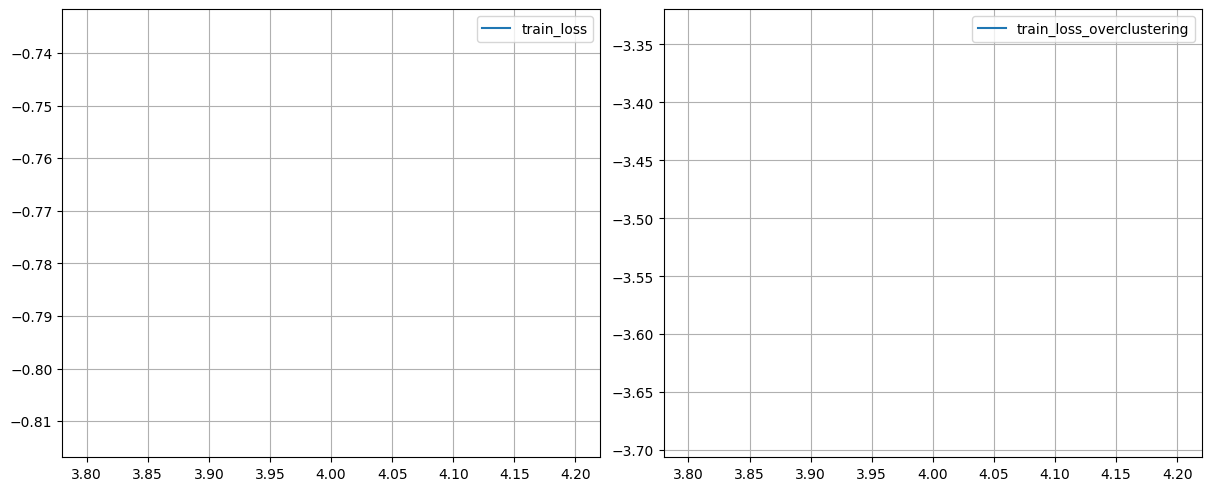

Epoch 6/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221]
[-3.5128734, -3.7193177]


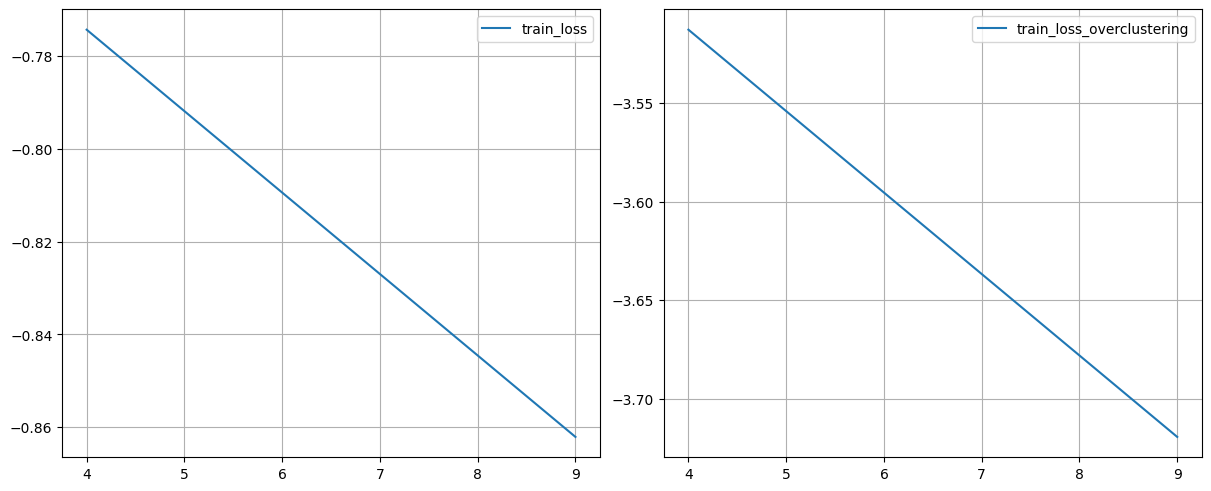

Epoch 11/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092]
[-3.5128734, -3.7193177, -2.9908636]


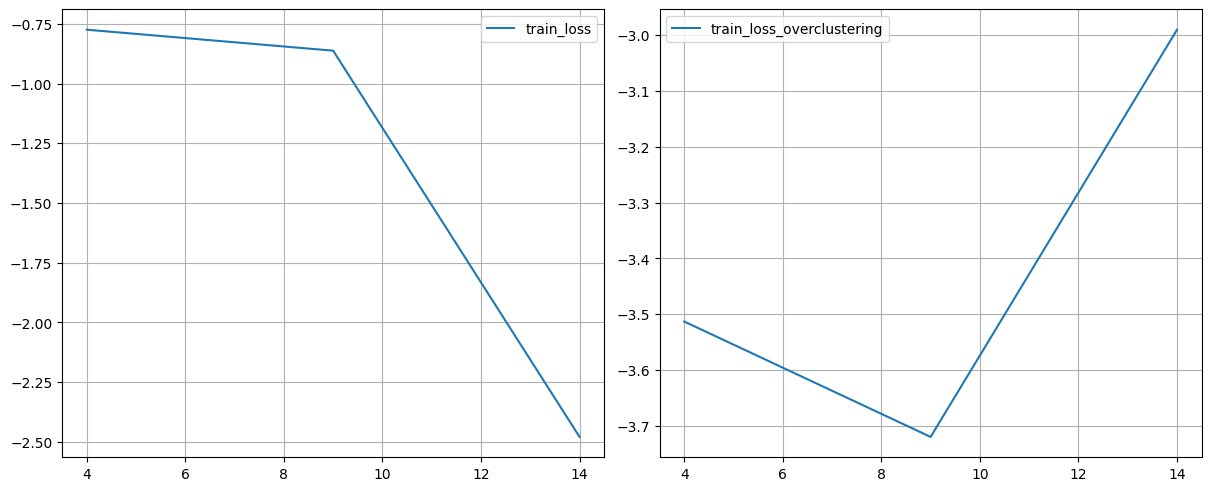

Epoch 16/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451]


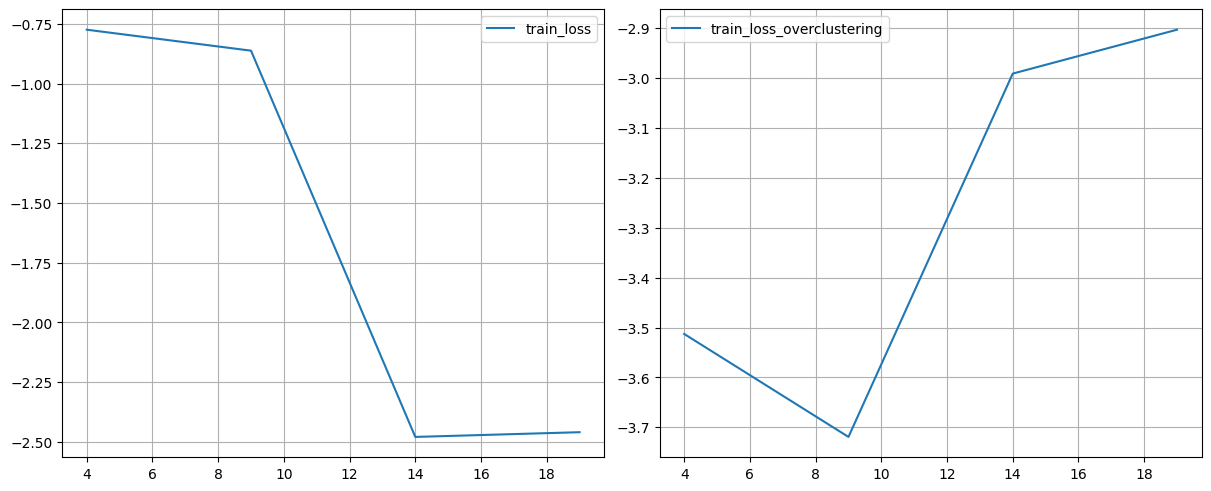

Epoch 21/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336]


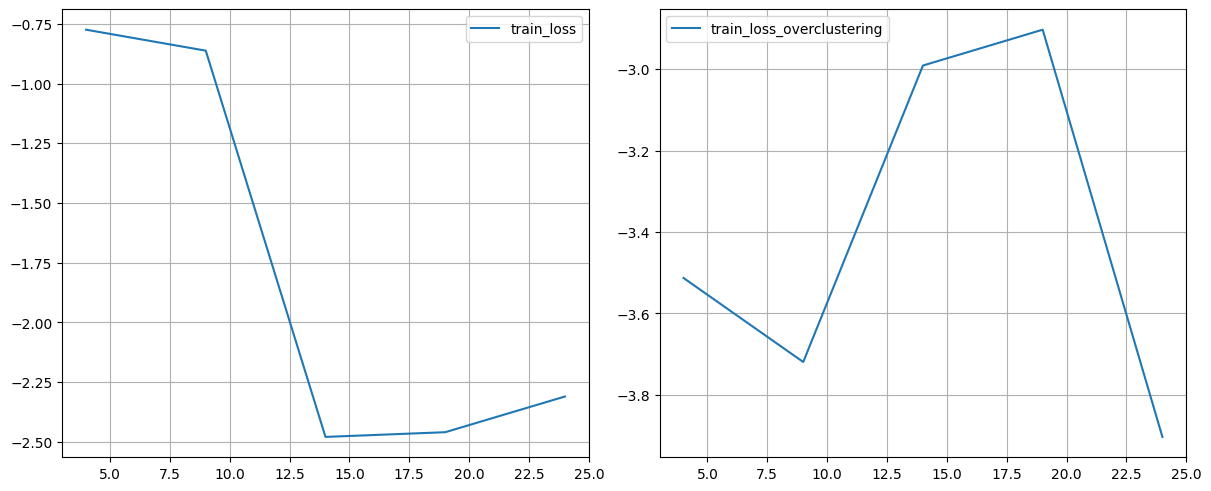

Epoch 26/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394]


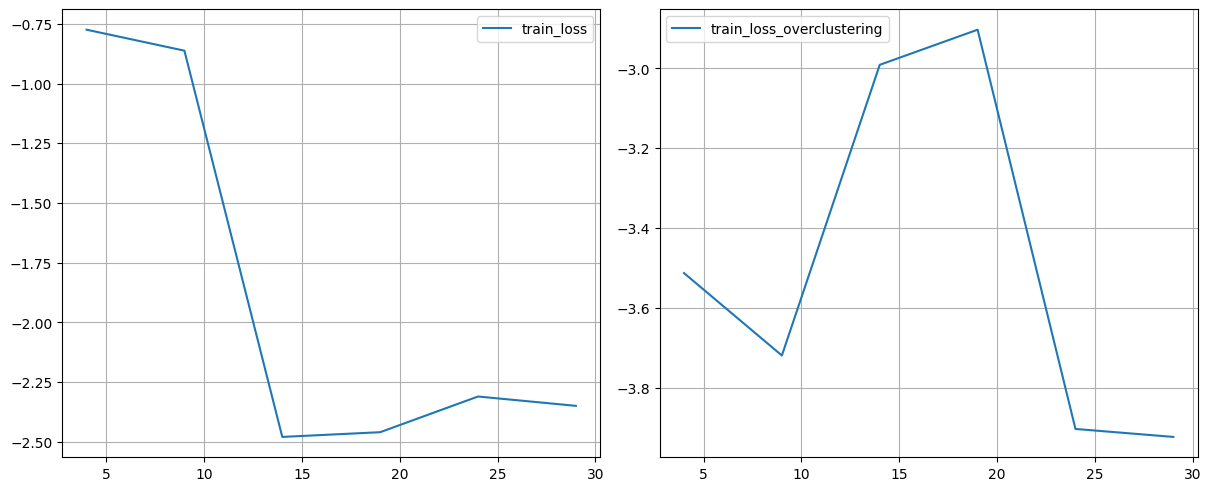

Epoch 31/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 32/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 33/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 34/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 35/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094]


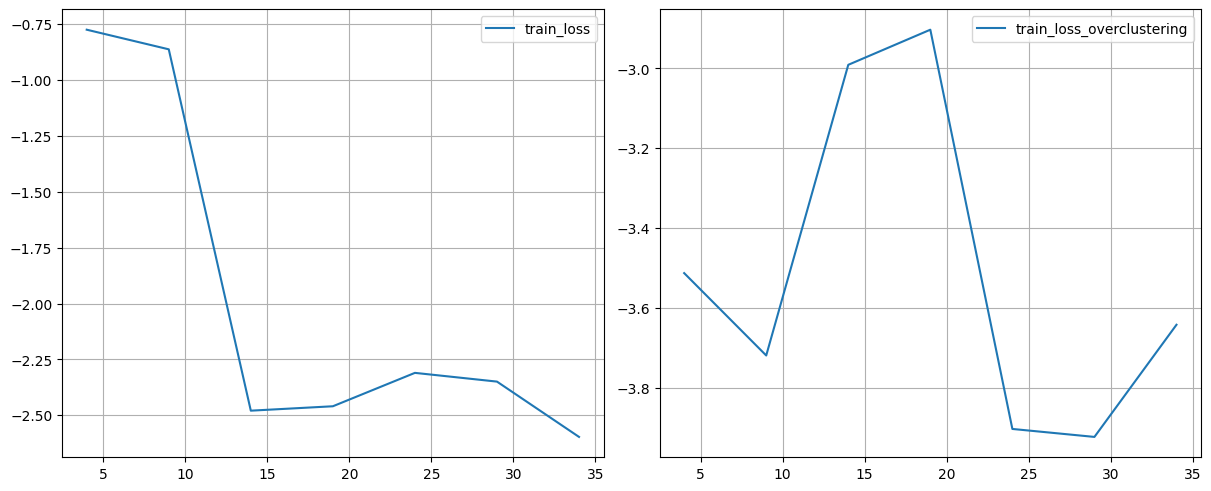

Epoch 36/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 37/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 38/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 39/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 40/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474]


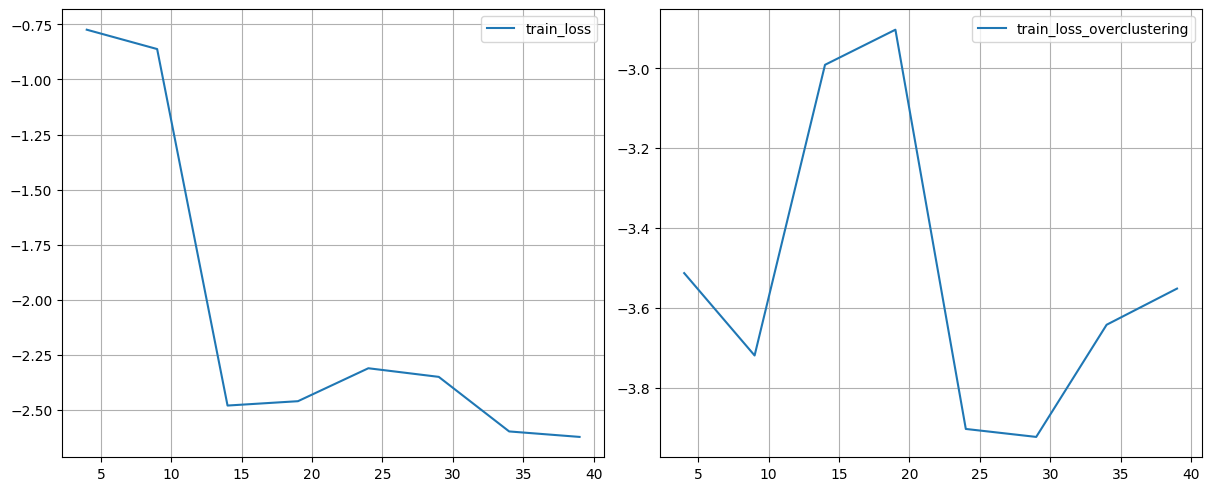

Epoch 41/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 42/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 43/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 44/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 45/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385]


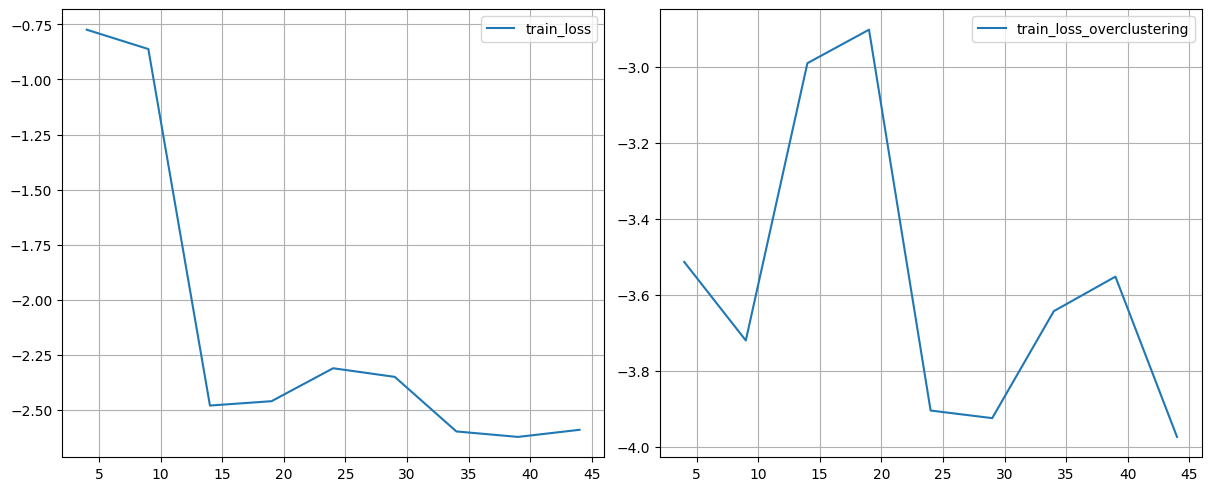

Epoch 46/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 47/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 48/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 49/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 50/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904]


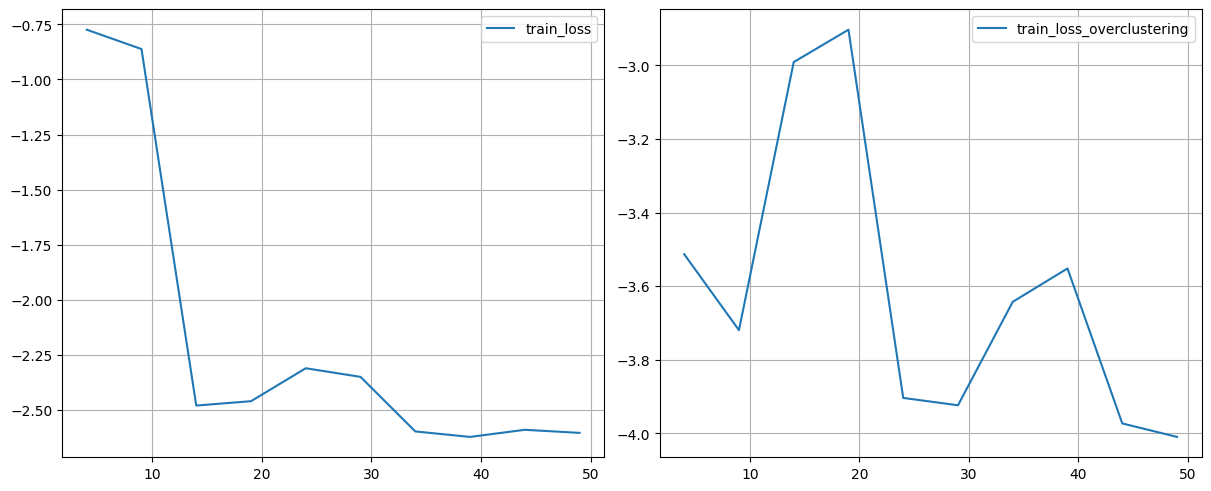

Epoch 51/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 52/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 53/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 54/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 55/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056]


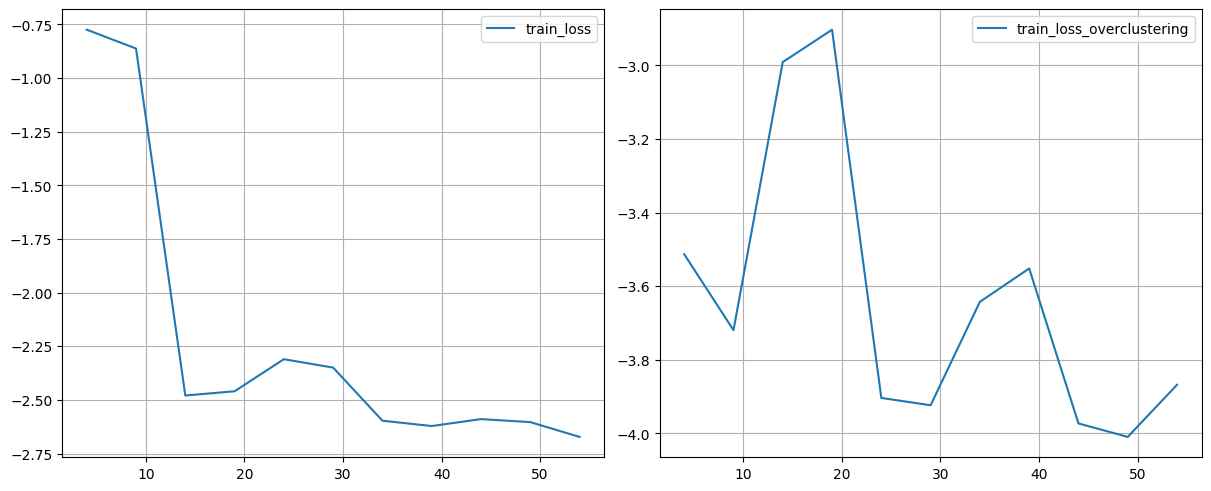

Epoch 56/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 57/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 58/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 59/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 60/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307]


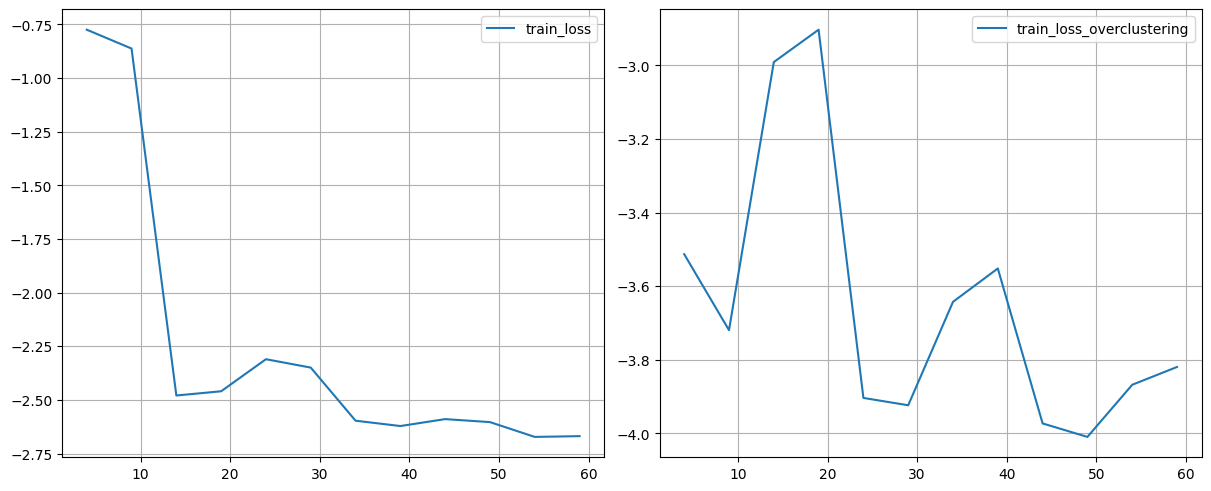

Epoch 61/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 62/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 63/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 64/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 65/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486]


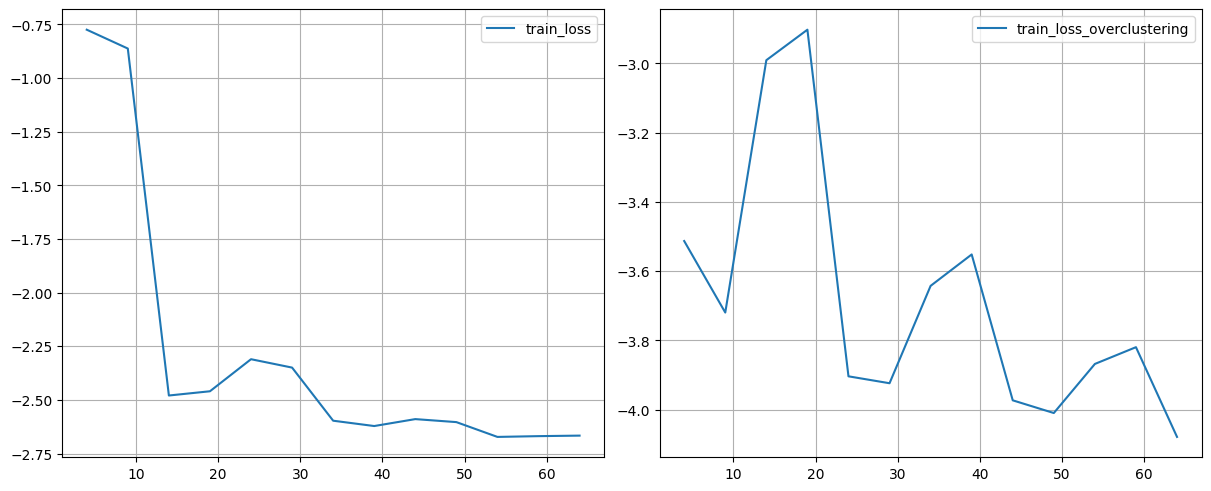

Epoch 66/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 67/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 68/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 69/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 70/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778, -2.6813743]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486, -4.051819]


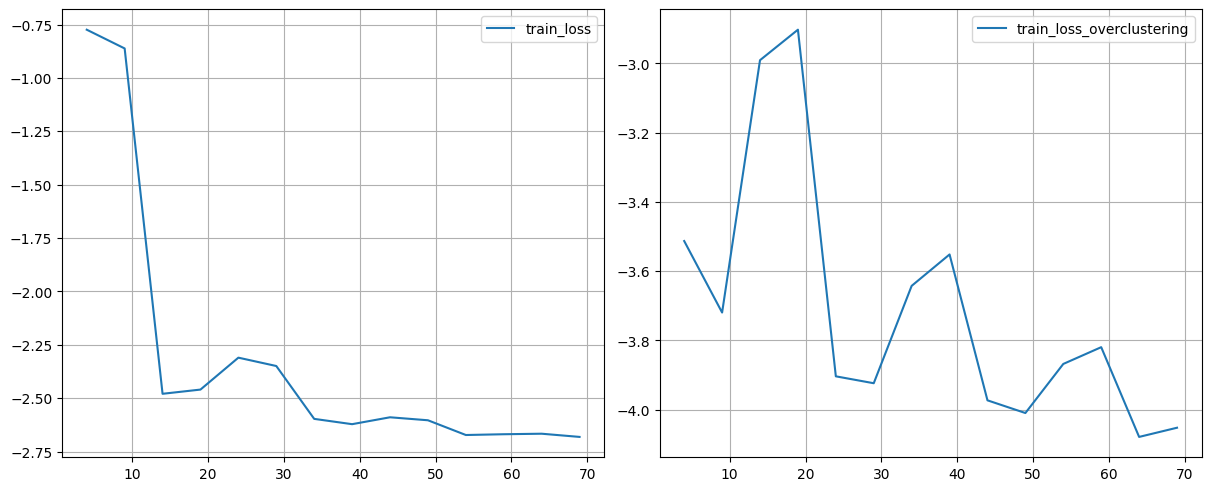

Epoch 71/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 72/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 73/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 74/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 75/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778, -2.6813743, -2.6799297]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486, -4.051819, -3.990862]


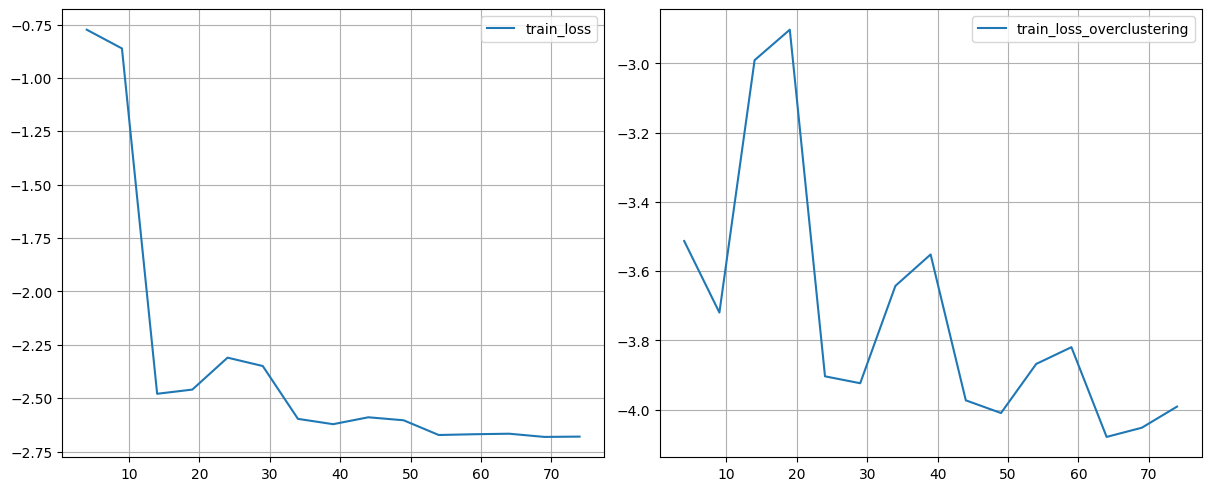

Epoch 76/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 77/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 78/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 79/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 80/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778, -2.6813743, -2.6799297, -2.7092679]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486, -4.051819, -3.990862, -3.977602]


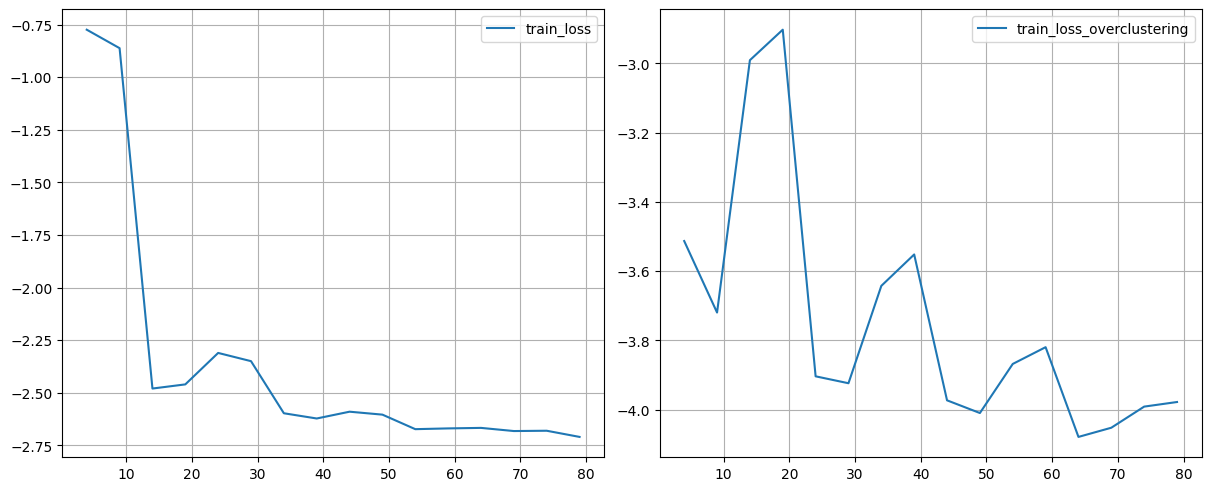

Epoch 81/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 82/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 83/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 84/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 85/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778, -2.6813743, -2.6799297, -2.7092679, -2.7266972]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486, -4.051819, -3.990862, -3.977602, -4.093121]


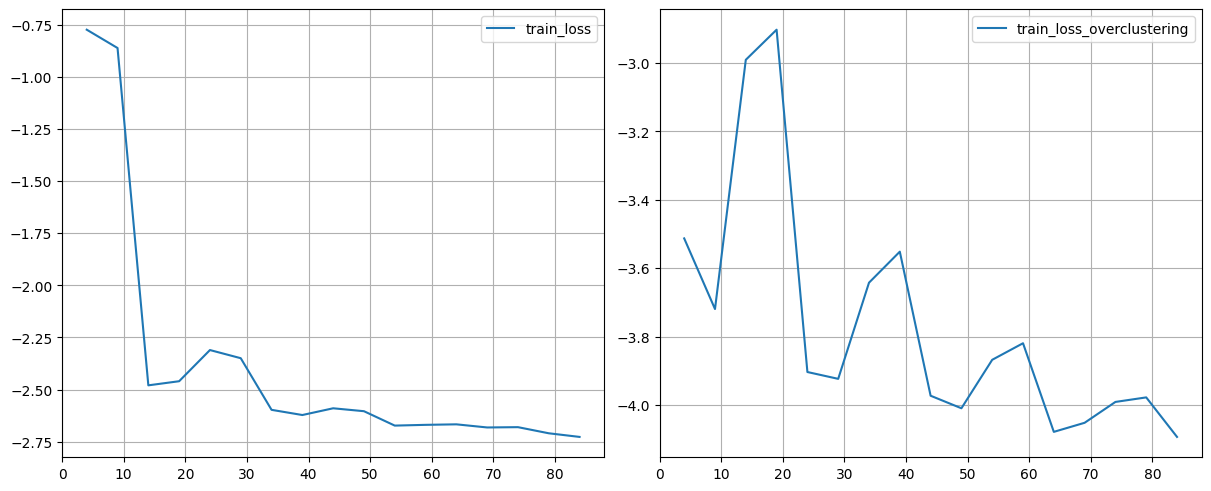

Epoch 86/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 87/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 88/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 89/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 90/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778, -2.6813743, -2.6799297, -2.7092679, -2.7266972, -2.7151766]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486, -4.051819, -3.990862, -3.977602, -4.093121, -4.0831895]


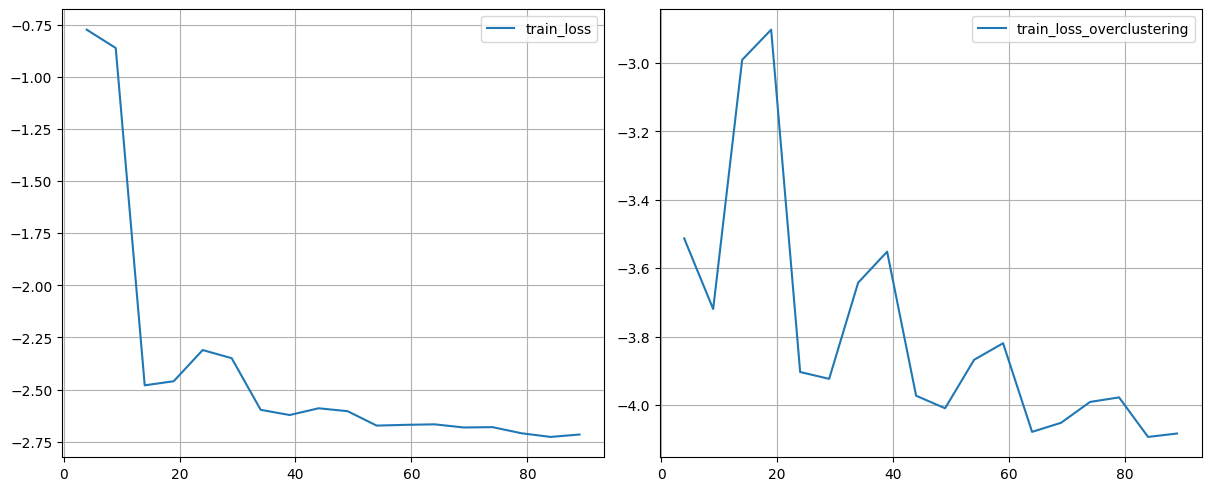

Epoch 91/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 92/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 93/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 94/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 95/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778, -2.6813743, -2.6799297, -2.7092679, -2.7266972, -2.7151766, -2.6835606]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486, -4.051819, -3.990862, -3.977602, -4.093121, -4.0831895, -4.0064845]


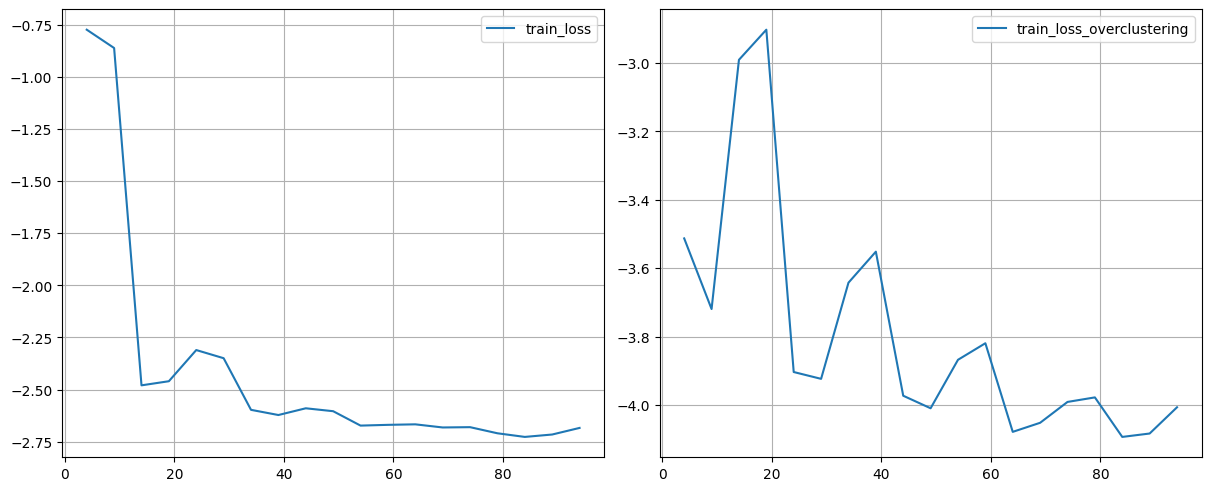

Epoch 96/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 97/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 98/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 99/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch 100/100:


  0%|          | 0/56 [00:00<?, ?it/s]

Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

Overhead Clustering Evaluation --->


  0%|          | 0/3 [00:00<?, ?it/s]

[-0.7742868, -0.8621221, -2.4794092, -2.459682, -2.310209, -2.349312, -2.5968745, -2.6217213, -2.5894349, -2.6034129, -2.6724336, -2.6688302, -2.6663778, -2.6813743, -2.6799297, -2.7092679, -2.7266972, -2.7151766, -2.6835606, -2.6758082]
[-3.5128734, -3.7193177, -2.9908636, -2.9028451, -3.9034336, -3.923394, -3.6423094, -3.5516474, -3.9727385, -4.0093904, -3.8677056, -3.819307, -4.0783486, -4.051819, -3.990862, -3.977602, -4.093121, -4.0831895, -4.0064845, -4.004527]


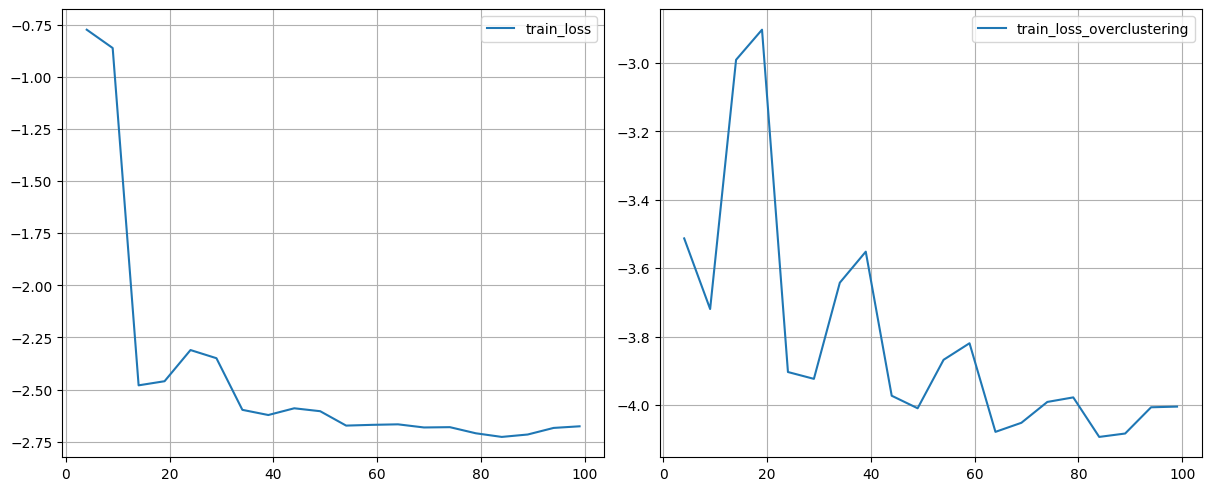

Best Clustering Loss Value: -2.7266972


In [ ]:
# training
optimizer = torch.optim.Adam(
    model.parameters(), lr=4e-4, betas=(0.9, 0.999), eps=1e-08,
    weight_decay=0, amsgrad=False)

train( model, dataloader_train, dataloader_val,
    optimizer, device=device, epochs=100, lamb=1.2,
    overcluster_period=20, overcluster_ratio=0.5)

**Loading best model**

In [ ]:
test_model = ResNetClusterisator()
test_model.load_state_dict(torch.load("/content/best_loss_model_mnist.pth"))
test_model.to(device)

ResNetClusterisator(
  (backbone): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
# data testing
original_labels, cluster_labels = model_test(
    test_model, dataloader_val, device=device
)

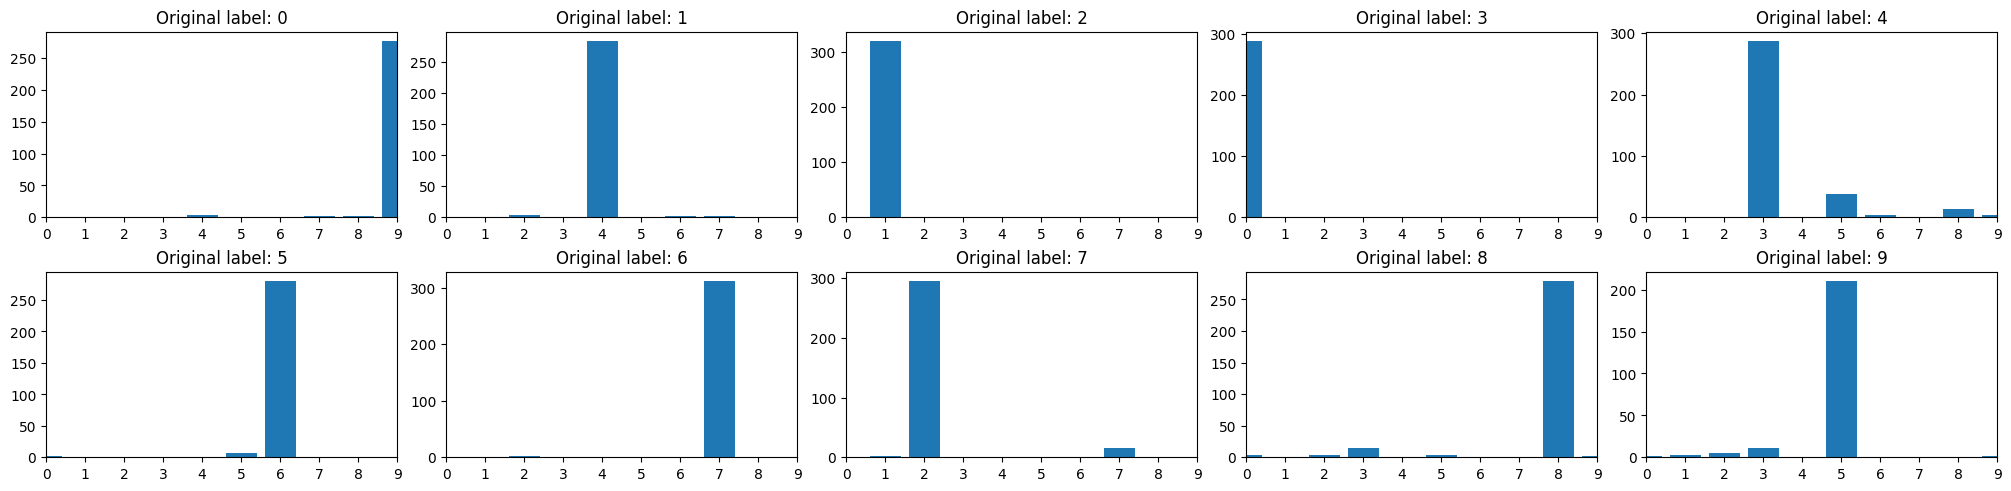

In [ ]:
# visualization
visualise_clusetering_results(original_labels, cluster_labels)

In [ ]:
adj_score = adjusted_rand_score(cluster_labels, original_labels)
hom_score = homogeneity_score(cluster_labels, original_labels)
compl_score = completeness_score(cluster_labels, original_labels)
print("Adjusted rand score: %.3f " % adj_score)
print("Homogeneity score: %.3f " % adj_score)
print("Completeness score: %.3f" % compl_score)

Adjusted rand score: 0.890 
Homogeneity score: 0.890 
Completeness score: 0.894


In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(np.array(cluster_labels).reshape(-1, 1), np.array(original_labels).reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7288095699401856

Semi Supervised classification

In [ ]:
def create_mapping(original_labels, cluster_labels):
    """Creates mapping from cluster labels to original labels.
    In each cluster the most frequent original label is chosen. This label is assumed to be cluster's true label
    Parameters
    ----------
    original_labels : list of int
        true labels of the data
    cluster_labels : list of int
        labels produced by a clustering algotithm
    Returns
    -------
    mapping : dict
        mapping from the clusters to original classes
    Notes
    -----
    This function should be used only if the clusters are well-defined
    """

    original_labels = np.array(original_labels, dtype=np.int)
    cluster_labels = np.array(cluster_labels, dtype=np.int)
    class_ids = np.unique(original_labels)
    cluster_ids = np.unique(cluster_labels)
    mapping = {}
    for cluster_id in cluster_ids:
        original_labels_in_cluster = original_labels[cluster_labels == cluster_id]
        map_to_id = np.bincount(original_labels_in_cluster).argmax()
        mapping[cluster_id] = map_to_id

    return mapping


In [ ]:
def print_mapping(mapping):
    """Visualises the mapping
    Parameters
    ----------
    mapping : dict (int to int)
        a mapping from clusters to classes
    """
    print("Cluster  Class")
    for key, value in mapping.items():
        print("%3i -----> %i" % (key, value))

<ipython-input-26-612ed12ba31e>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  original_labels = np.array(original_labels, dtype=np.int)
<ipython-input-26-612ed12ba31e>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprec

Cluster  Class
  0 -----> 9
  1 -----> 4
  2 -----> 1
  3 -----> 0
  4 -----> 3
  5 -----> 6
  6 -----> 7
  7 -----> 2
  8 -----> 8
  9 -----> 5


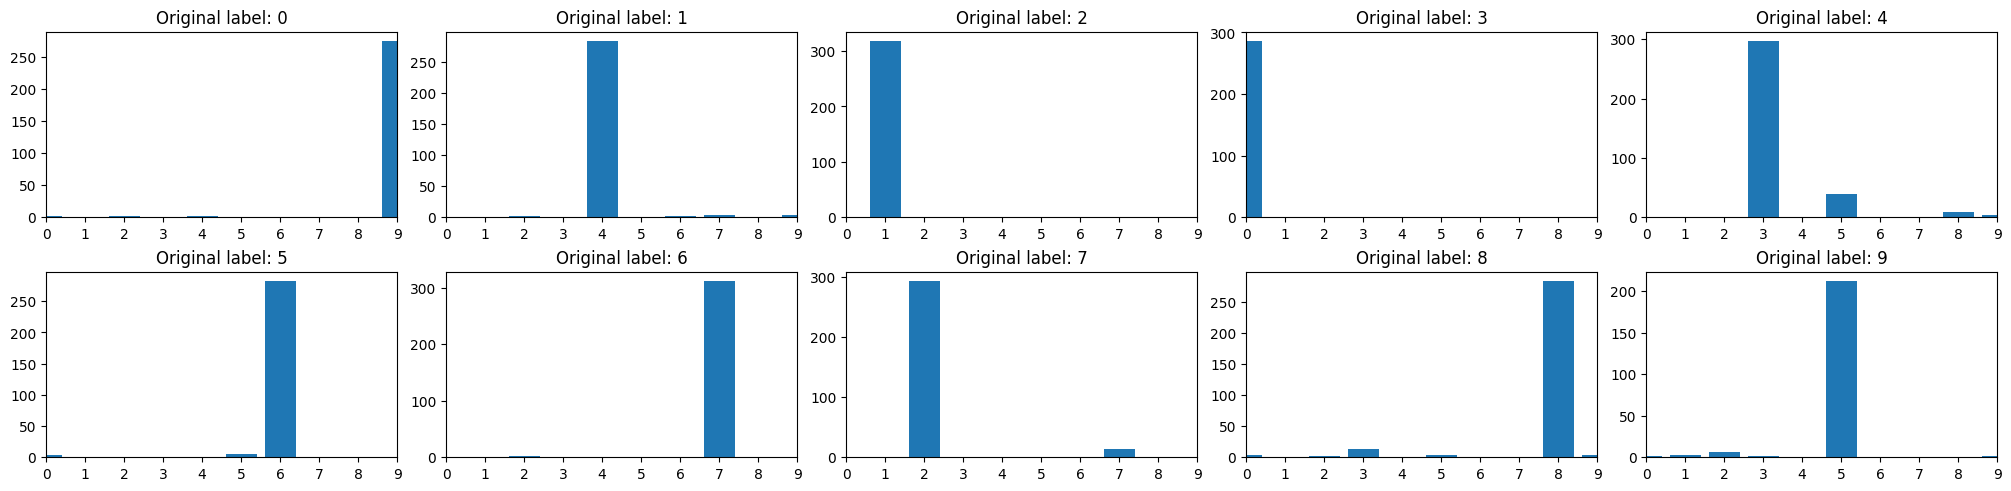

In [ ]:
original_labels, cluster_labels = model_test(
    model, dataloader_val, device=device
)
visualise_clusetering_results(original_labels, cluster_labels)
cluster_mapping = create_mapping(original_labels, cluster_labels)
cluster_labels_mapped = [cluster_mapping[x] for x in cluster_labels]
print_mapping(cluster_mapping)

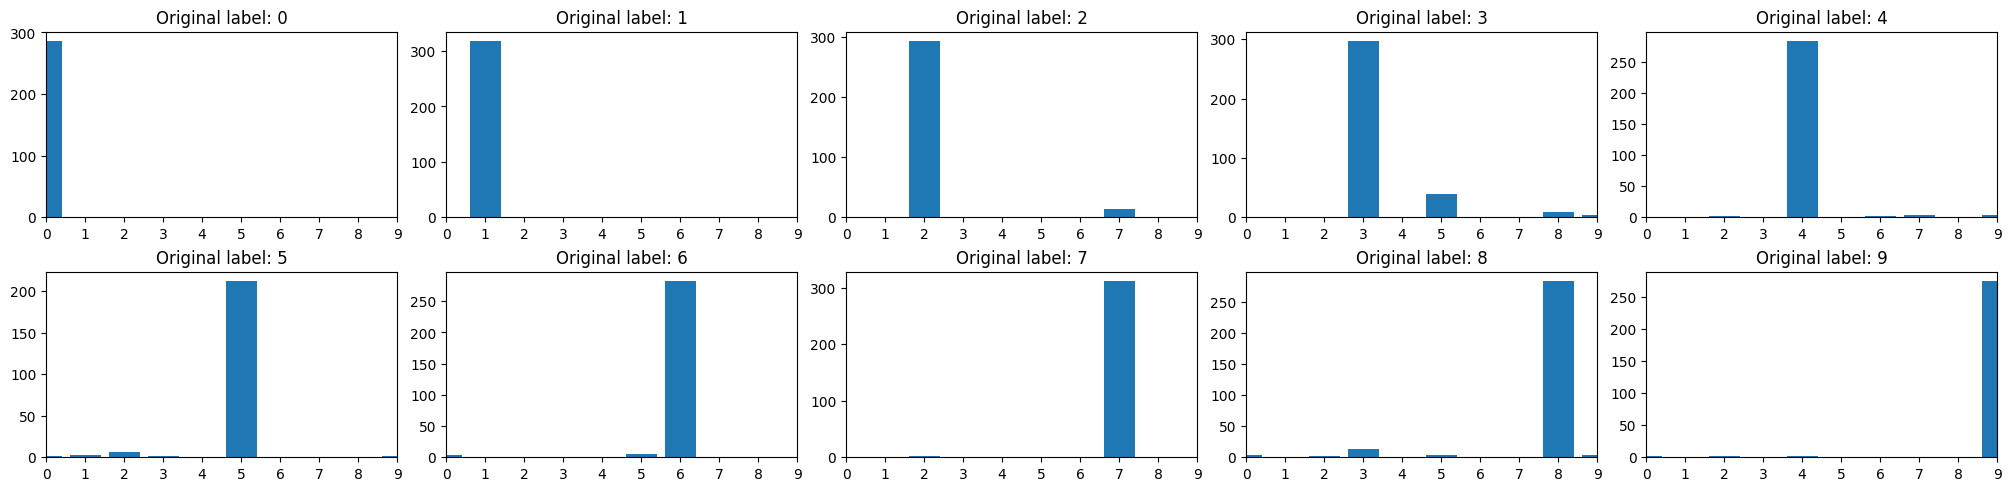

In [ ]:
visualise_clusetering_results(original_labels, cluster_labels_mapped)

In [ ]:
accuracy_score(original_labels, cluster_labels_mapped)

0.951